# Coronavirus Workbook

## Setup 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from langdetect import detect
import datetime
import unicodedata
import re
from IPython.display import display, HTML
pd.set_option('display.notebook_repr_html', True)

This CSV comes from the data provider. We just want timestamp, data, location, and unique user ID.

In [2]:
df = pd.read_csv("/home/npgentry/Dropbox/org/data/be/8f1528-7ed8-40fb-b549-0c652975b83d/cv/filtered.csv", 
                 encoding="cp1252")
df = df.drop(['id', 'screen_name'], axis=1)
df.location = df.location.apply(
    lambda v: unicodedata.normalize('NFKD', v).encode('ascii', 'ignore').decode()
)
df.ts = pd.to_datetime(df.ts)
print(df.shape)
df.head()

(4258, 4)


,ts,data,location,uid
0,2020-02-28 23:42:51+00:00,RT MikeBloomberg: Shouldn’t you be worrying ab...,New York,2.654832e+07
1,2020-03-05 23:43:42+00:00,RT mattdpearce: Pretty stark statement from a ...,New York,2.654832e+07
2,2020-03-05 23:45:11+00:00,Starbucks canceled their annual meeting of sha...,??? Tokyo,2.084434e+07
3,2020-01-27 21:06:27+00:00,Lost a few followers due to my tweets.. I gues...,10x Views are thine own,2.999031e+07
4,2020-02-15 17:06:02+00:00,Sidragon1 elkentaro I'm wondering which spread...,"181 Metro Dr 6 San Jose, CA",2.202322e+09


Let's filter out all the junk location data and only keep the locations we know about, which we compute by a simple greedy substring match against the list of known cities.

In [3]:
cities = pd.read_csv("/home/npgentry/Dropbox/org/data/be/8f1528-7ed8-40fb-b549-0c652975b83d/cv/worldcities.csv")
cities = cities.city_ascii.reindex(
    cities.city_ascii.str.len().sort_values(ascending=False).index
)
rex = '|'.join(cities) + r'|$'
df.location = df.location.apply(
    lambda l: re.search(rex, l)[0]
)
df = df.loc[df.location != '']

I also wonder how many unique locations we have.

In [4]:
len(df.location.unique())

121

We also want to bin by languages, so let's detect the language of the remaining posts.

In [5]:
try: 
    languages
except:
    languages = [detect(d) for d in df.data]

In [6]:
df['lang'] = languages
df.lang.value_counts().to_frame()

,lang
en,1528
es,1412
ca,43
it,9
pt,8
fr,4
de,2


I wonder what the most popular languages are, and the most populated locations.

In [7]:
df.location.value_counts().to_frame()

,location
Mexico,1120
New York,424
Mexico City,206
Washington,167
San Diego,97
...,...
Bakersfield,1
Olympia,1
Charlotte,1
Northbrook,1


## Sample queries

Many of the operations here come from this excellent [Kaggle tutorial](https://www.kaggle.com/residentmario/grouping-and-sorting). I finally understand how pandas groupings work, and this notation is becomeing as intuitive as SQL. MultiIndices are pretty cool.

In [8]:
df.groupby([pd.Grouper(key='ts', freq='M'), df.location, df.lang]).data.count().to_frame()

data
ts                        location      lang      
2020-01-31 00:00:00+00:00 Atlanta       ca       1
                                        en       1
                                        es       8
                          Atlantic City en       5
                          Auburn        en       1
...                                            ...
2020-03-31 00:00:00+00:00 Wall          en       1
                          Washington    en      50
                          We            en       3
                          Westminster   en       4
                          Wyoming       en       1

[258 rows x 1 columns]

1. What are the languages used in each month, sorted in descending order of frequency?

In [9]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    tdf = df.groupby([pd.Grouper(key='ts', freq='M'), df.lang]).data.count()
    display(tdf.reset_index().sort_values(['ts', 'data'], ascending=[True, False]).set_index(['ts', 'lang']))

data
ts                        lang      
2020-01-31 00:00:00+00:00 es     520
                          en     293
                          ca      17
                          pt       3
2020-02-29 00:00:00+00:00 en     848
                          es     740
                          ca      19
                          it       5
                          pt       4
                          de       2
                          fr       2
2020-03-31 00:00:00+00:00 en     387
                          es     152
                          ca       7
                          it       4
                          fr       2
                          pt       1

2. What are the languages used in each location each month, sorted in total posts per location and then in descending order of language frequency?

In [10]:
with pd.option_context('display.max_rows', 50, 'display.max_columns', None):
    tdf = df.groupby([pd.Grouper(key='ts', freq='M'), df.location, df.lang]).data.count().to_frame()
    tdf['sum'] = tdf.groupby(level=[0, 1])['data'].transform('sum')
    tdf = tdf.reset_index().sort_values(
        ['ts', 'sum', 'location', 'data'], ascending=[True, False, True, False]
    ).drop('sum', axis=1).set_index(['ts', 'location', 'lang'])
    
    # just show the first month
    display(tdf.xs(tdf.index[0][0]).head(12))

data
location    lang      
Mexico      es     391
            ca      12
            en       7
            pt       2
New York    en      86
Mexico City es      82
Washington  en      35
Morelia     es      20
            ca       3
            en       1
Doha        en      17
Guadalajara es      17

3. What were the number of Catalan posts in each location per month, sorted in descencing order of post frequency?

This solution uses the rather sneaky `IndexSlice`, which I read about [here](https://www.somebits.com/~nelson/pandas-multiindex-slice-demo.html).

In [11]:
display(tdf.loc[pd.IndexSlice[:,:,['ca']],:].sort_values(['ts', 'data'], ascending=[True, False]))

data
ts                        location lang      
2020-01-31 00:00:00+00:00 Mexico   ca      12
                          Morelia  ca       3
                          Atlanta  ca       1
                          York     ca       1
2020-02-29 00:00:00+00:00 Mexico   ca      17
                          Morelia  ca       2
2020-03-31 00:00:00+00:00 Mexico   ca       6
                          Morelia  ca       1

What location had the most Catalan posts, in each given month?

In [12]:
tdf.loc[pd.IndexSlice[:,:,['en']],:].sort_values(['ts', 'data'], ascending=[True, False]).groupby(level=[0]).head(1)

,,,data
ts,location,lang,
2020-01-31 00:00:00+00:00,New York,en,86
2020-02-29 00:00:00+00:00,New York,en,247
2020-03-31 00:00:00+00:00,New York,en,91


What are the most multilinugual locations? We aren't just asking how many posts there are per language; we want to know how many languages there are represented. So we need some form of _diversity score_.

## Tensor construction

In [13]:
import tensorflow as tf
import tensorly as tl
tl.set_backend('numpy')

We will create a sample tensor on a sample of month, city, and language. We want to get dense data, so let's choose the most representative examples.

In [14]:
sample_cities = ["Washington","Sydney","San Diego", "New York", "Hyderabad"]
sample_langs = ['en', 'es', 'it']
sdf = df.loc[
    df.location.str.contains('|'.join(sample_cities)) & df.lang.isin(sample_langs)
]

In [15]:
pretensor = sdf.groupby([pd.Grouper(key='ts', freq='M'), sdf.location, sdf.lang]).data.count().to_frame()
pretensor.xs(tdf.index[0][0])

,,data
location,lang,
Hyderabad,en,3
New York,en,86
San Diego,en,3
Sydney,en,9
Washington,en,35


In [16]:
# https://stackoverflow.com/questions/35047882/transform-pandas-dataframe-with-n-level-hierarchical-index-into-n-d-numpy-array
shape = map(len, pretensor.index.levels)
arr = np.zeros(list(shape))
arr[tuple(pretensor.index.codes)] = pretensor.values.flat
tensor = tl.tensor(arr)
tensor

array([[[  3.,   0.,   0.],
        [ 86.,   0.,   0.],
        [  3.,   0.,   0.],
        [  9.,   0.,   0.],
        [ 35.,   0.,   0.]],

       [[ 50.,   3.,   4.],
        [247.,   0.,   0.],
        [ 81.,   0.,   0.],
        [ 22.,   0.,   0.],
        [ 82.,   0.,   0.]],

       [[ 13.,   0.,   1.],
        [ 91.,   0.,   0.],
        [ 13.,   0.,   0.],
        [ 18.,   0.,   0.],
        [ 50.,   0.,   0.]]])

In [17]:
from tensorly.decomposition import parafac

weights, factors = parafac(tensor, rank=2)
factors

[array([[ -90.88994244,    1.76306985],
        [-277.09502882,   -2.03137052],
        [-105.1205647 ,    1.60478434]]),
 array([[ 0.15128399,  2.12626483],
        [ 0.89441475, -0.27273976],
        [ 0.22963445,  4.46880567],
        [ 0.09730267, -1.20494124],
        [ 0.33774158, -2.87094272]]),
 array([[-1.00000784e+00, -1.92957151e+00],
        [-1.30826858e-03, -3.85380304e-02],
        [-1.91041975e-03, -4.12296270e-02]])]

## Latent Dirchlet allocation

We first take the following santizing steps, which come from [this great guide](https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/calculate-tweet-word-frequencies-in-python/).
 1. Remove all punctuation and URLs;
 2. Change all text to lowercaase

In [18]:
endf = df.loc[df.lang == 'en']

endf['data'] = endf['data'].map(lambda x: x.lower()).map(
    lambda x: re.sub('[,\.!?]|(https?.*)|rt', '', x)
)

/home/npgentry/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Our next goal is creating a histogram. Let's get raw word frequency and remove stop words.

In [19]:
import nltk

try:
    stops = set(nltk.corpus.stopwords.words('english'))
except:
    nltk.download('stopwords')
    stops = set(nltk.corpus.stopwords.words('english'))

We also want to remove collection words, which would skew our analysis otherwise. A good heuristic for other uninteresting words is word length -- particularly in this dataset, where we have words like "RT" and "US" floating around everywhere.

In [20]:
collections = ['coronavirus', 'outbreak', 'cases', 'says']

In [21]:
freqs = endf.data.str.split(' ', expand=True).stack().value_counts().to_frame().reset_index()
freqs.columns = ['word', 'freq']

freqs = freqs.loc[
    freqs.word.str.len().ge(3) & freqs.word.str.contains('\w+') & 
    ~freqs.word.isin(collections) & ~freqs.word.isin(stops)
]

The word cloud will give us a good idea of where we are going.

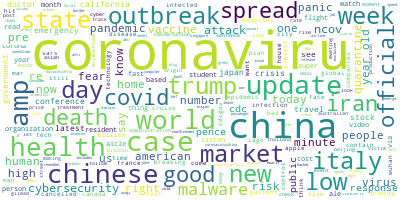

In [22]:
from wordcloud import WordCloud
long_string = ','.join(list(freqs.word.values))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=2, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

Now let's make a good ol' histogram.

Unique words:  5696


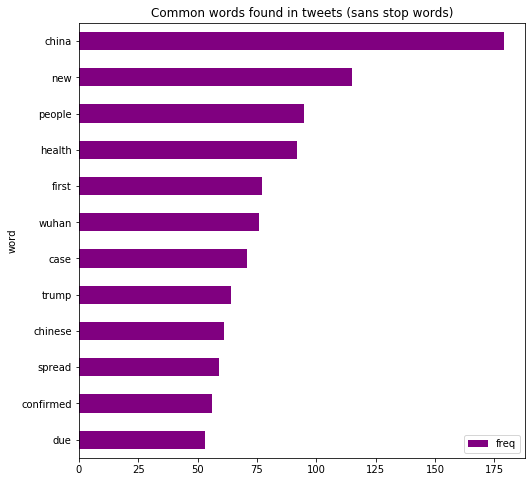

In [23]:
print("Unique words: ", len(freqs.word))

fig, ax = plt.subplots(figsize=(8, 8))
freqs.sort_values(by="freq").tail(12).plot.barh(x='word', y='freq', ax=ax, color="purple")
ax.set_title("Common words found in tweets (sans stop words)")
plt.show()

Now, we can do LDA. Note that I am not really using the pandas implementation above; we can just let scikitlearn do all the tokenizing and processing for us. I read the alternate approach in [this tutorial](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0).

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(stop_words='english')
count_data = count_vectorizer.fit_transform(endf.data)

In [25]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)# Load the LDA model from sk-learn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
number_topics = 6
number_words = 10
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)#
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
coronavirus china wuhan outbreak death new toll people case virus

Topic #1:
coronavirus china new health case cases confirmed officials people breaking

Topic #2:
coronavirus china trump outbreak cases spread new novel cdc people

Topic #3:
coronavirus outbreak china chinese public people says cases ve know

Topic #4:
coronavirus people chinese outbreak concerns new mardi china gras tested

Topic #5:
coronavirus cruise ship pence mike response vice tested president princess
